# Master video notebook!
This title might be a bit ambitious, but this notebook is supposed to be able to do all of the administration work when it comes to analysing videos. Of course, many functions are already inherent to the kymo_class file and the plot_data file. Ultimately, this notebook is about creating a file hierarchy for the analysis files.

In step one, the Dropbox is scoured for information about videos. If the videos do not have a VideoInfo.txt, the program will look for a .csv, if there is no .csv, the program will look for a .xlsx file. This is currently in conflict with what is happening in the kymo_class.py file, so that one will have to be amended.

### Let's say that there are three ways to initiate a kymograph class:
1. No info file is submitted, and the class will look for such a file itself.
2. An info file is submitted, and the class will use the data in there.
3. A kymograph is submitted, and the class will instantiate with the parameters that are passed with the kymograph.

TODO: Make it so in the kymo_class
TODO: Streamline the variable storage such that edge properties are stored in the edge_analysis class, and video properties are stored in the video_analysis class.

### Below code:
Are just import statements

In [1]:
from IPython.display import clear_output
import re
from amftrack.pipeline.development.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset
)
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    save_raw_data,
    plot_summary,
    read_video_data
)
import sys
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
import matplotlib as mpl

from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer

import dropbox
from amftrack.util.dbx import upload_folders, download, read_saved_dropbox_state, save_dropbox_state, load_dbx, download, get_dropbox_folders, get_dropbox_video_folders
from subprocess import call
import logging
import datetime
import glob
import json
from amftrack.pipeline.launching.run_super import run_parallel_flows


logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams['figure.dpi'] = 300


/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-07-13 09:19:38.138372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 09:19:38.838457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:

## File declaration
As this notebook is designed to work with Snellius, two items to separate are the raw video files and the anaylsis. The raw video files are large, bulky and not so easy to flip through. Ideally, the video files would be downloaded and the analysis would be stored on a separate folder structure entirely. That way, large scale analysis of analysis folders can happen when there are thousands of videos in the dataset, without having to have those raw video folders on hand.

### Input and output:
Please give separately the folder where raw video data is stored, and where the analysis will be stored. 
Also give the dropbox address of the dataset you want to analyze, this is the first filtering step.

In [2]:
videos_folder = "F:\\AMOLF_Data\\videos\\"
analysis_folder = "F:\\AMOLF_Data\\analysis\\"

videos_folder = "/gpfs/scratch1/shared/amftrackflow/videos/"
analysis_folder = "/gpfs/home6/svstaalduine/Analysis/"

In [3]:
dropbox_address = "/DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate510/"
# dropbox_address=  "/DATA/MYRISTATE/DATA/"
# dropbox_address = "/DATA/TransportROOT/DATA/"
# dropbox_address = "/DATA/CocoTransport/"

## Where to go?
If you want to download videos:
Use MODULE 1

If you want to analyze already downloaded videos:
Skip MODULE 1, use MODULE 2

# Module 1: Downloading videos from DropBox

## Dropbox scrounging
The below code is meant to scour the dropbox for information files on the videos. It is also to create a list of the videos within a certain database. The expectation at the very least is that one plate contains many videos, all labeled with a number. The code will take this list, and recreate the hierarchy within the Analysis_Output folder.

### Input:
The input will be the highest folder of the dropbox that needs to be analyzed. You can also set REDO_SCROUNGING to True if you want the dropbox scrounging to happen no maatter what.

### Output
The output will be a DataFrame that can be filtered in the next code block to prepare for downloading. In addition, .json files will also be created for the specific file that is recorded in the input. That way, scrounging the dropbox only has to be done once. 

In [23]:
REDO_SCROUNGING = False

analysis_json = f"{analysis_folder}{dropbox_address[6:]}all_folders_drop.json"
if os.path.exists(analysis_json):
    all_folders_drop = pd.read_json(analysis_json)
excel_json = f"{analysis_folder}{dropbox_address[6:]}excel_drop.json"
if os.path.exists(excel_json):
    excel_drop = pd.read_json(excel_json, typ='series')
if not os.path.exists(analysis_json) or REDO_SCROUNGING:
    all_folders_drop, excel_drop, txt_drop = get_dropbox_video_folders(dropbox_address, True)

    clear_output(wait=False)
    
    excel_addresses = np.array([re.search("^.*Plate.*\/.*Plate.*$", entry, re.IGNORECASE) for entry in excel_drop])
    excel_addresses = excel_addresses[excel_addresses != None]
    excel_addresses = [address.group(0) for address in excel_addresses]
    excel_drop = np.concatenate([excel_addresses,txt_drop])
    if not os.path.exists(f"{analysis_folder}{dropbox_address[6:]}"):
        os.makedirs(f"{analysis_folder}{dropbox_address[6:]}")
    all_folders_drop.to_json(analysis_json)
    pd.Series(excel_drop).to_json(excel_json)
    print(all_folders_drop['tot_path_drop'][0])
    
all_folders_drop 

folder  Plate number  Date Imaged  \
0    Img           403     20230703   

                                  tot_path_drop video  
0  DATA/CocoTransport/20230703_Plate403/001/Img   Img

In [24]:
info_addresses  = []
for address in excel_drop:
    csv_name_len = len(address.split(os.sep)[-1])
    if not os.path.exists(analysis_folder + address[6:-csv_name_len]):
        os.makedirs(analysis_folder + address[6:-csv_name_len])
    if not os.path.exists(analysis_folder + address[6:]):
        download(address, analysis_folder + address[6:])
    info_addresses.append(analysis_folder + address[6:])
clear_output(wait=False)
print("All files downloaded!")

All files downloaded!


In [30]:
merge_frame = read_video_data(info_addresses, all_folders_drop, analysis_folder)
merge_frame

100%|██████████| 1/1 [00:00<00:00, 333.15it/s]


imaging_day                storage_path           plate_id    root strain  \
0    20230703  Dropbox\DATA\CocoTransport  20230703_Plate403  Carrot     C2   

      treatment crossing_day  video_int  time_(s) mode  ...  Fiber Led  \
0  001P100N100C     20230626          1      30.0   BF  ...         On   

     xpos  ypos   zpos            unique_id  \
0  12.266  0.32  5.993  AMOLF_Data_analysis   

                                   tot_path  \
0  CocoTransport\20230703_Plate403\001\Img\   

                                   tot_path_drop  record_time  \
0  DATA\CocoTransport\20230703_Plate403\001\Img\     16:45:29   

   days_after_crossing magnification  
0                    7          50.0  

[1 rows x 25 columns]

## Dropbox filtering
If you want all videos in a plate or dataset, you can run this block and forget about it.
Otherwise, this block is where filtering can take place to only download videos with certain properties, like imaging mode. Then a file structure will be created in the videos and analysis folder, and videoInfo.txt folders are created for every video, in the analysis folder. The intent here is to have a uniform Analysis folder structure that works with the Morrison setup.

### Input
Use the section between commented lines to filter the DataFrame, otherwise leave blank
### Output
Within the video and analysis folder, a hierarchy will be created to mimic that of the dropbox folder structure, using the filtered DataFrame. Inside the analysis folder hierarchy, the VideoInfo.txt file will be generated. Either from an existing videoInfo.txt, or the excel/csv sheets.

In [32]:
#####################################################################################
### This is where you can apply the filters. Only those videos will be downloaded ###
#####################################################################################

download_frame = merge_frame

#####################################################################################
### Below code will prepare for those videos to be downloaded into videos_folder  ###
#####################################################################################

download_frame = download_frame.rename(columns={'tot_path' : 'folder'})
download_frame = download_frame.sort_values('unique_id')
download_frame = download_frame.reset_index(drop=True)
download_frame = download_frame.loc[:,~download_frame.columns.duplicated()].copy()

download_frame

imaging_day                storage_path           plate_id    root strain  \
0    20230703  Dropbox\DATA\CocoTransport  20230703_Plate403  Carrot     C2   

      treatment crossing_day  video_int  time_(s) mode  ...  Fiber Led  \
0  001P100N100C     20230626          1      30.0   BF  ...         On   

     xpos  ypos   zpos            unique_id  \
0  12.266  0.32  5.993  AMOLF_Data_analysis   

                                     folder  \
0  CocoTransport\20230703_Plate403\001\Img\   

                                   tot_path_drop  record_time  \
0  DATA\CocoTransport\20230703_Plate403\001\Img\     16:45:29   

   days_after_crossing magnification  
0                    7          50.0  

[1 rows x 25 columns]

In [33]:
download_frame['analysis_folder'] = [np.nan for i in range(len(download_frame))]
download_frame['videos_folder'] = [np.nan for i in range(len(download_frame))]
# download_frame = download_frame.drop(columns=['index'], axis=1)

for index, row in download_frame.iterrows():
    target_anals_file = f"{analysis_folder}{row['folder'][:-4]}"
#     print(target_anals_file)
    target_video_file = f"{videos_folder}{row['folder']}"
    
    row.loc['analysis_folder'] = target_anals_file
    row.loc['videos_folder'] = target_video_file
    
    if not os.path.exists(target_anals_file):
        os.makedirs(target_anals_file)
    if not os.path.exists(target_video_file):
        os.makedirs(target_video_file)
#     print(row.index)
    row.to_json(f"{target_anals_file}/video_data.json", orient="index")

## Downloading
This section, there is one block of code that will ask you one last time whether all of the parameters are correct. The block of code after that will initiate Snellius jobs to download the videos in the DataFrame from the dropbox. Downloading videos is not that costly, but of course we prefer it to be done as efficiently as possible.
### Input:
Nothing
### Output:
Print statement with the DataFrame and the folders where everything will be stored.
Subsequent block of code will download raw video files to the videos folder.

In [34]:
print("Below videos will be downloaded!")
download_frame

Below videos will be downloaded!


imaging_day                storage_path           plate_id    root strain  \
0    20230703  Dropbox\DATA\CocoTransport  20230703_Plate403  Carrot     C2   

      treatment crossing_day  video_int  time_(s) mode  ...  ypos   zpos  \
0  001P100N100C     20230626          1      30.0   BF  ...  0.32  5.993   

             unique_id                                    folder  \
0  AMOLF_Data_analysis  CocoTransport\20230703_Plate403\001\Img\   

                                   tot_path_drop record_time  \
0  DATA\CocoTransport\20230703_Plate403\001\Img\    16:45:29   

   days_after_crossing  magnification  analysis_folder videos_folder  
0                    7           50.0              NaN           NaN  

[1 rows x 27 columns]

In [17]:
run_parallel_transfer(
    "from_drop.py",
    [videos_folder],
    download_frame,
    1,
    "10:00:00",
    "transfer_test"
)
clear_output(wait=False)

print("Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress")

Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress


# Module 2: Analysis
Now that the files have been downloaded, it's time to analyse them. In the below code, you'll be able to either do a complete survey of the analysis folder for as many videos as possible, or use the DataFrame of recently downloaded videos to filter for the videos you want to analyse.

### Input:
DataFrame filters of all videos to be analysed
### Output:
Print statements for all parameters of the analysis session that is about to take place.

In [4]:
print(dropbox_address)

/DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate510/


In [5]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient='index').T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values('unique_id').reset_index(drop=True)
vid_anls_frame

index             unique_id treatment strain days_after_crossing grow_temp  \
0      0  20221208_plate510_01  1%P100%N     C2                   7      25.0   
1      1  20221208_plate510_02  1%P100%N     C2                   7      25.0   
2      2  20221208_plate510_03  1%P100%N     C2                   7      25.0   
3      3  20221208_plate510_04  1%P100%N     C2                   7      25.0   
4      4  20221208_plate510_05  1%P100%N     C2                   7      25.0   
..   ...                   ...       ...    ...                 ...       ...   
65    65  20221208_plate510_66  1%P100%N     C2                   7      25.0   
66    66  20221208_plate510_67  1%P100%N     C2                   7      25.0   
67    67  20221208_plate510_68  1%P100%N     C2                   7      25.0   
68    68  20221208_plate510_69  1%P100%N     C2                   7      25.0   
69    69  20221208_plate510_70  1%P100%N     C2                   7      25.0   

     xpos   ypos dcenter droot  ...  \
0   34840  46900    -9.0  -4.0  ...   
1   34760  46960    -9.0  -4.0  ...   
2   34760  46960    -9.0  -4.0  ...   
3   33640  46380   -10.0  -3.0  ...   
4   33640  46380   -10.0  -3.0  ...   
..    ...    ...     ...   ...  ...   
65  31820  45740   -12.0  -2.0  ...   
66  31820  45740   -12.0  -2.0  ...   
67  31820  45740   -12.0  -2.0  ...   
68  30940  45640   -13.0  -2.0  ...   
69  30940  45640   -13.0  -2.0  ...   

                                         comments           plate_id plate_nr  \
0                                            None  20221208_Plate510    510.0   
1                                            None  20221208_Plate510    510.0   
2                                            None  20221208_Plate510    510.0   
3                                            None  20221208_Plate510    510.0   
4                                            None  20221208_Plate510    510.0   
..                                            ...                ...      ...   
65                                           None  20221208_Plate510    510.0   
66                                           None  20221208_Plate510    510.0   
67                                           None  20221208_Plate510    510.0   
68                                           None  20221208_Plate510    510.0   
69  Shaking incubator turned on during this video  20221208_Plate510    510.0   

   imaging_day                                      tot_path_drop  \
0   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
1   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
2   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
3   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
4   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
..         ...                                                ...   
65  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
66  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
67  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
68  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
69  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   

         plate_id_csv         unique_id_csv  \
0   20221208_Plate510   20221208_Plate510_1   
1   20221208_Plate510   20221208_Plate510_2   
2   20221208_Plate510   20221208_Plate510_3   
3   20221208_Plate510   20221208_Plate510_4   
4   20221208_Plate510   20221208_Plate510_5   
..                ...                   ...   
65  20221208_Plate510  20221208_Plate510_66   
66  20221208_Plate510  20221208_Plate510_67   
67  20221208_Plate510  20221208_Plate510_68   
68  20221208_Plate510  20221208_Plate510_69   
69  20221208_Plate510  20221208_Plate510_70   

                                               folder  \
0   FLUORESCENCE/DATA_NileRed/20221208_Plate510/DA...   
1   FLUORESCENCE/DATA_NileRed/20221208_Plate510/DA...   
2   FLUORESCENCE/DATA_N

In [9]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################

analysis_frame = vid_anls_frame

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################

print(analysis_frame['unique_id'].to_string())

0    20230703_Plate403_001


## Run Analysis job
Two options: For small analysis, use the first block. This will just do the calculations on the machine. For large-scale analysis, use the second block, as it will create a Snellius job.
## Input:
Snellius job parameters
## Output:
Analysis folder will be populated with analysis tiffs and csv sheets.

In [ ]:
### LARGE VIDEO ANALYSIS

nr_parallel = np.min([len(analysis_frame.index), 16])

run_parallel_flows(
    "flux_extract.py",
    [analysis_folder, 15, 0.95, 0.005, 60, dropbox_address],
    analysis_frame,
    nr_parallel,
    "2:00:00",
    "flux_extract"
)

# Module 3: Bulk Analysis
## First part: Assemble Edge DataFrame


In this initial part of the bulk analysis, all of the analysis folders will be looked through to find the edge data we're looking for. Additionally, there is an optional part to download the analysis folder back to the analysis folder we specified right at the top.

## Assuming all the videos are already downloaded:
You can use below code to read the video_data.json files that are created during indexing of all the videos

In [6]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient='index').T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values('unique_id').reset_index(drop=True)

In [7]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################

vid_anls_frame = vid_anls_frame

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################

In [16]:
plt.close('all')

data_obj = HighmagDataset(vid_anls_frame)
data_obj.dataset

Couldn't find the edges data file. Check analysis for 20221208_plate510_47


index             unique_id treatment strain days_after_crossing grow_temp  \
0      0  20221208_plate510_01  1%P100%N     C2                   7      25.0   
1      1  20221208_plate510_02  1%P100%N     C2                   7      25.0   
2      2  20221208_plate510_03  1%P100%N     C2                   7      25.0   
3      3  20221208_plate510_04  1%P100%N     C2                   7      25.0   
4      4  20221208_plate510_05  1%P100%N     C2                   7      25.0   
..   ...                   ...       ...    ...                 ...       ...   
65    65  20221208_plate510_66  1%P100%N     C2                   7      25.0   
66    66  20221208_plate510_67  1%P100%N     C2                   7      25.0   
67    67  20221208_plate510_68  1%P100%N     C2                   7      25.0   
68    68  20221208_plate510_69  1%P100%N     C2                   7      25.0   
69    69  20221208_plate510_70  1%P100%N     C2                   7      25.0   

     xpos   ypos dcenter droot  ...  \
0   34840  46900    -9.0  -4.0  ...   
1   34760  46960    -9.0  -4.0  ...   
2   34760  46960    -9.0  -4.0  ...   
3   33640  46380   -10.0  -3.0  ...   
4   33640  46380   -10.0  -3.0  ...   
..    ...    ...     ...   ...  ...   
65  31820  45740   -12.0  -2.0  ...   
66  31820  45740   -12.0  -2.0  ...   
67  31820  45740   -12.0  -2.0  ...   
68  30940  45640   -13.0  -2.0  ...   
69  30940  45640   -13.0  -2.0  ...   

                                         comments           plate_id plate_nr  \
0                                            None  20221208_Plate510    510.0   
1                                            None  20221208_Plate510    510.0   
2                                            None  20221208_Plate510    510.0   
3                                            None  20221208_Plate510    510.0   
4                                            None  20221208_Plate510    510.0   
..                                            ...                ...      ...   
65                                           None  20221208_Plate510    510.0   
66                                           None  20221208_Plate510    510.0   
67                                           None  20221208_Plate510    510.0   
68                                           None  20221208_Plate510    510.0   
69  Shaking incubator turned on during this video  20221208_Plate510    510.0   

   imaging_day                                      tot_path_drop  \
0   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
1   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
2   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
3   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
4   20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
..         ...                                                ...   
65  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
66  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
67  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
68  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   
69  20221208.0  DATA/FLUORESCENCE/DATA_NileRed/20221208_Plate5...   

         plate_id_csv         unique_id_csv  \
0   20221208_Plate510   20221208_Plate510_1   
1   20221208_Plate510   20221208_Plate510_2   
2   20221208_Plate510   20221208_Plate510_3   
3   20221208_Plate510   20221208_Plate510_4   
4   20221208_Plate510   20221208_Plate510_5   
..                ...                   ...   
65  20221208_Plate510  20221208_Plate510_66   
66  20221208_Plate510  20221208_Plate510_67   
67  20221208_Plate510  20221208_Plate510_68   
68  20221208_Plate510  20221208_Plate510_69   
69  20221208_Plate510  20221208_Plate510_70   

                                               folder  \
0   FLUORESCENCE/DATA_NileRed/20221208_Plate510/DA...   
1   FLUORESCENCE/DATA_NileRed/20221208_Plate510/DA...   
2   FLUORESCENCE/DATA_N

Index, edge name
0     (88, 12)
1     (88, 35)
2    (108, 88)


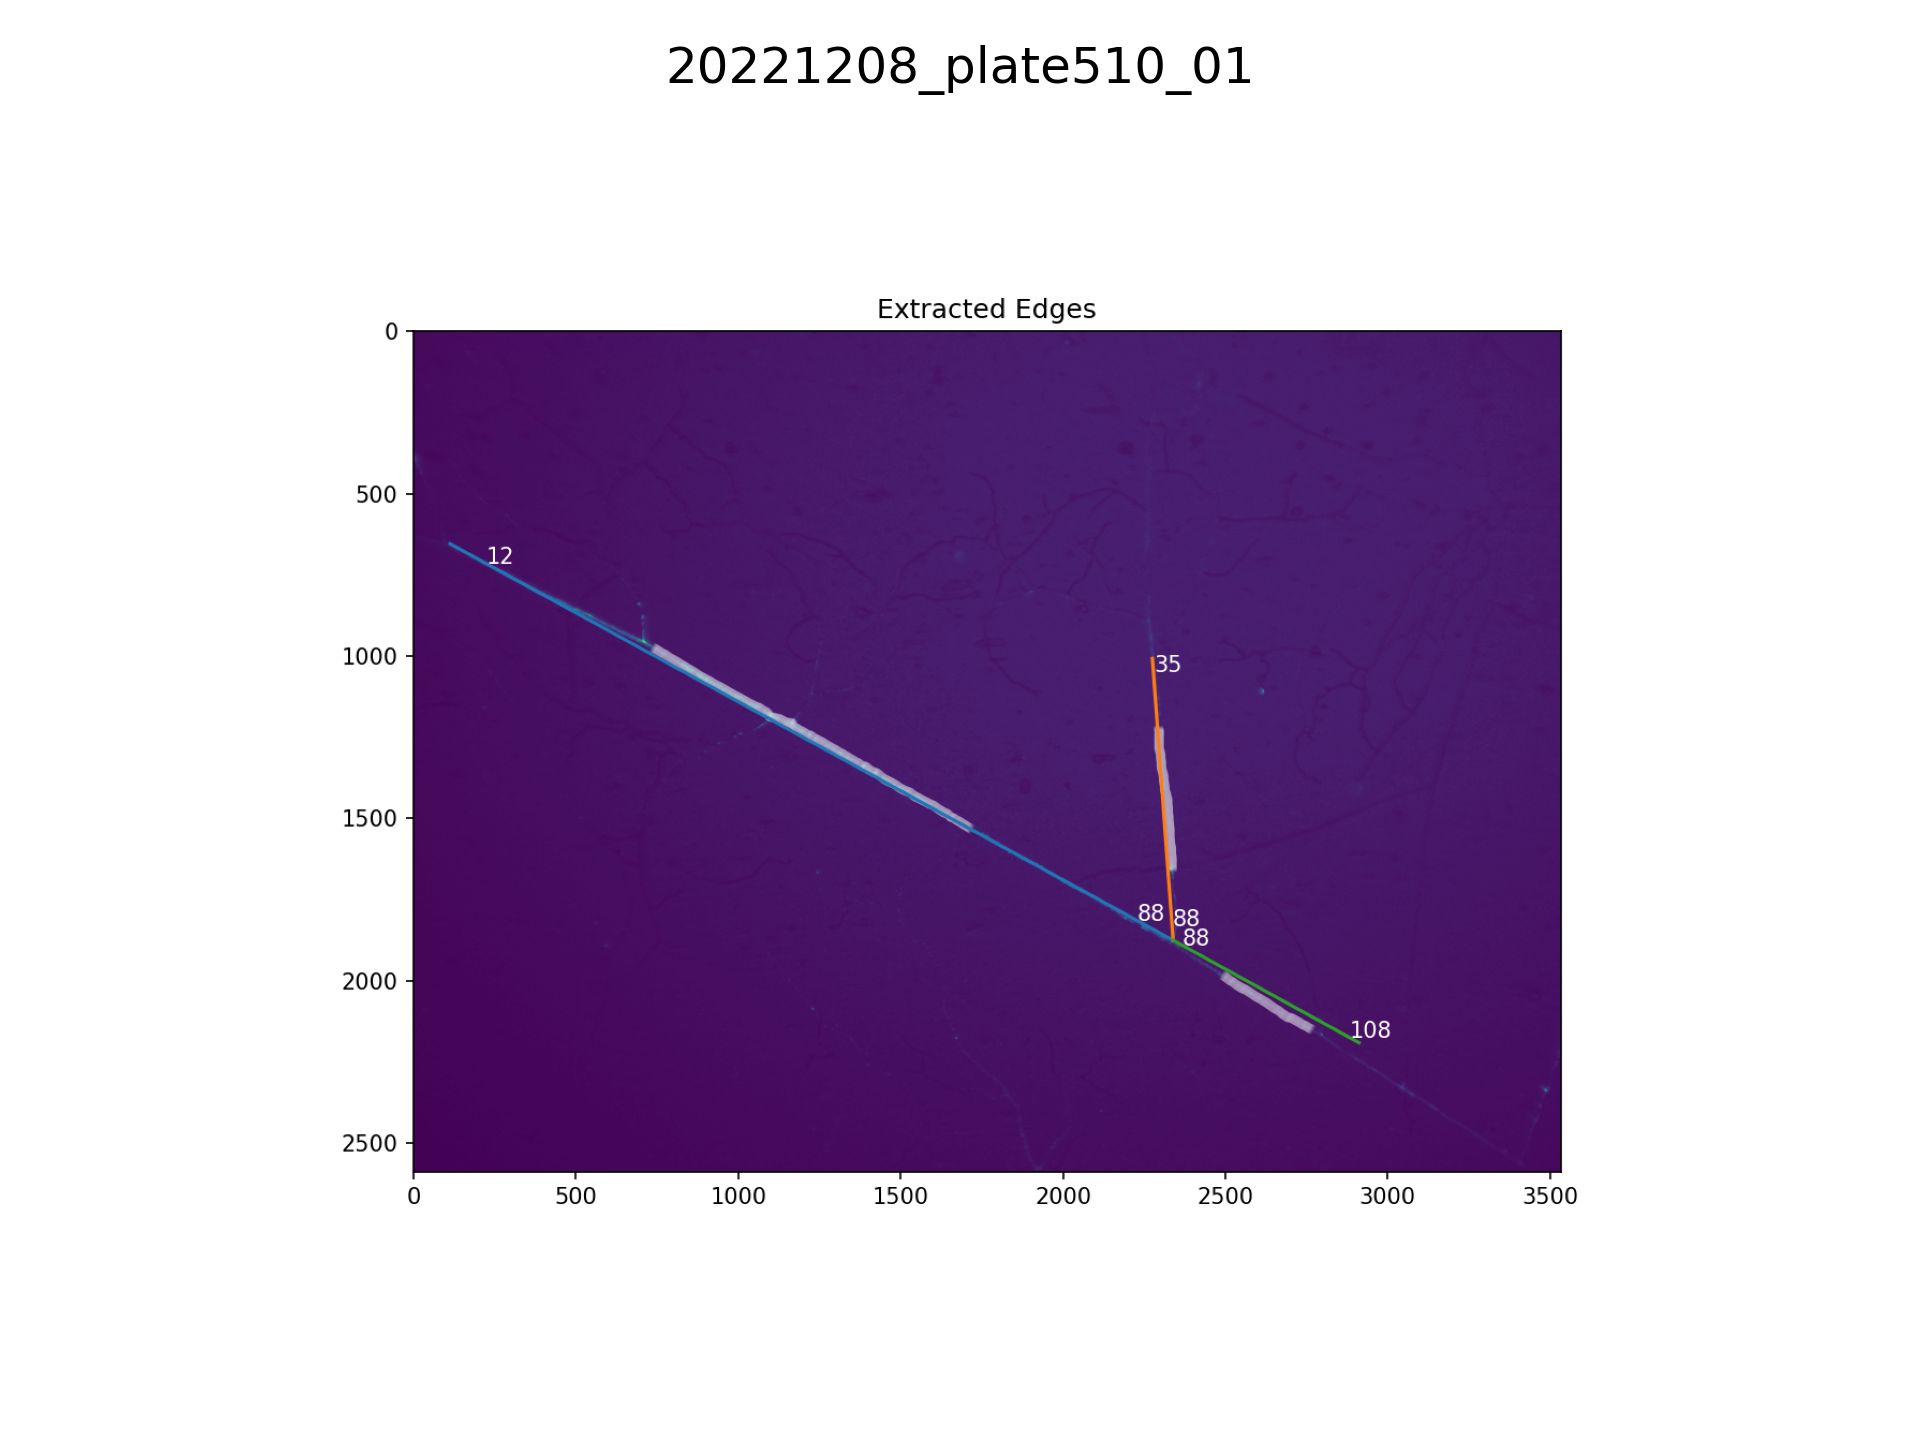

In [10]:
coco_vid = data_obj.video_objs[0]
coco_vid.show_summary()

Unnamed: 0  edge_name  edge_length  straight_length  speed_max  speed_min  \
0           0   (88, 12)      993.600      2431.127879   6.400348  -3.717595   
1           0  (108, 88)      274.275       564.222687  10.747547  -9.115156   

   speed_mean  flux_avg   flux_min    flux_max  ...  speed_right  \
0    0.110666  4.122058 -74.220796  117.001641  ...     2.408335   
1    0.462249  8.981539 -64.404060   89.025538  ...     3.971438   

   speed_left_std  speed_right_std  coverage_left  coverage_right  \
0        1.613868         1.651213       0.835437        0.799156   
1        2.429701         2.576482       0.349329        0.389720   

   coverage_tot  edge_xpos_1  edge_ypos_1  edge_xpos_2  edge_ypos_2  
0      0.969343       1087.0       1356.0        379.0         65.0  
1      0.581059       1270.0       1688.0       1087.0       1356.0  

[2 rows x 22 columns]

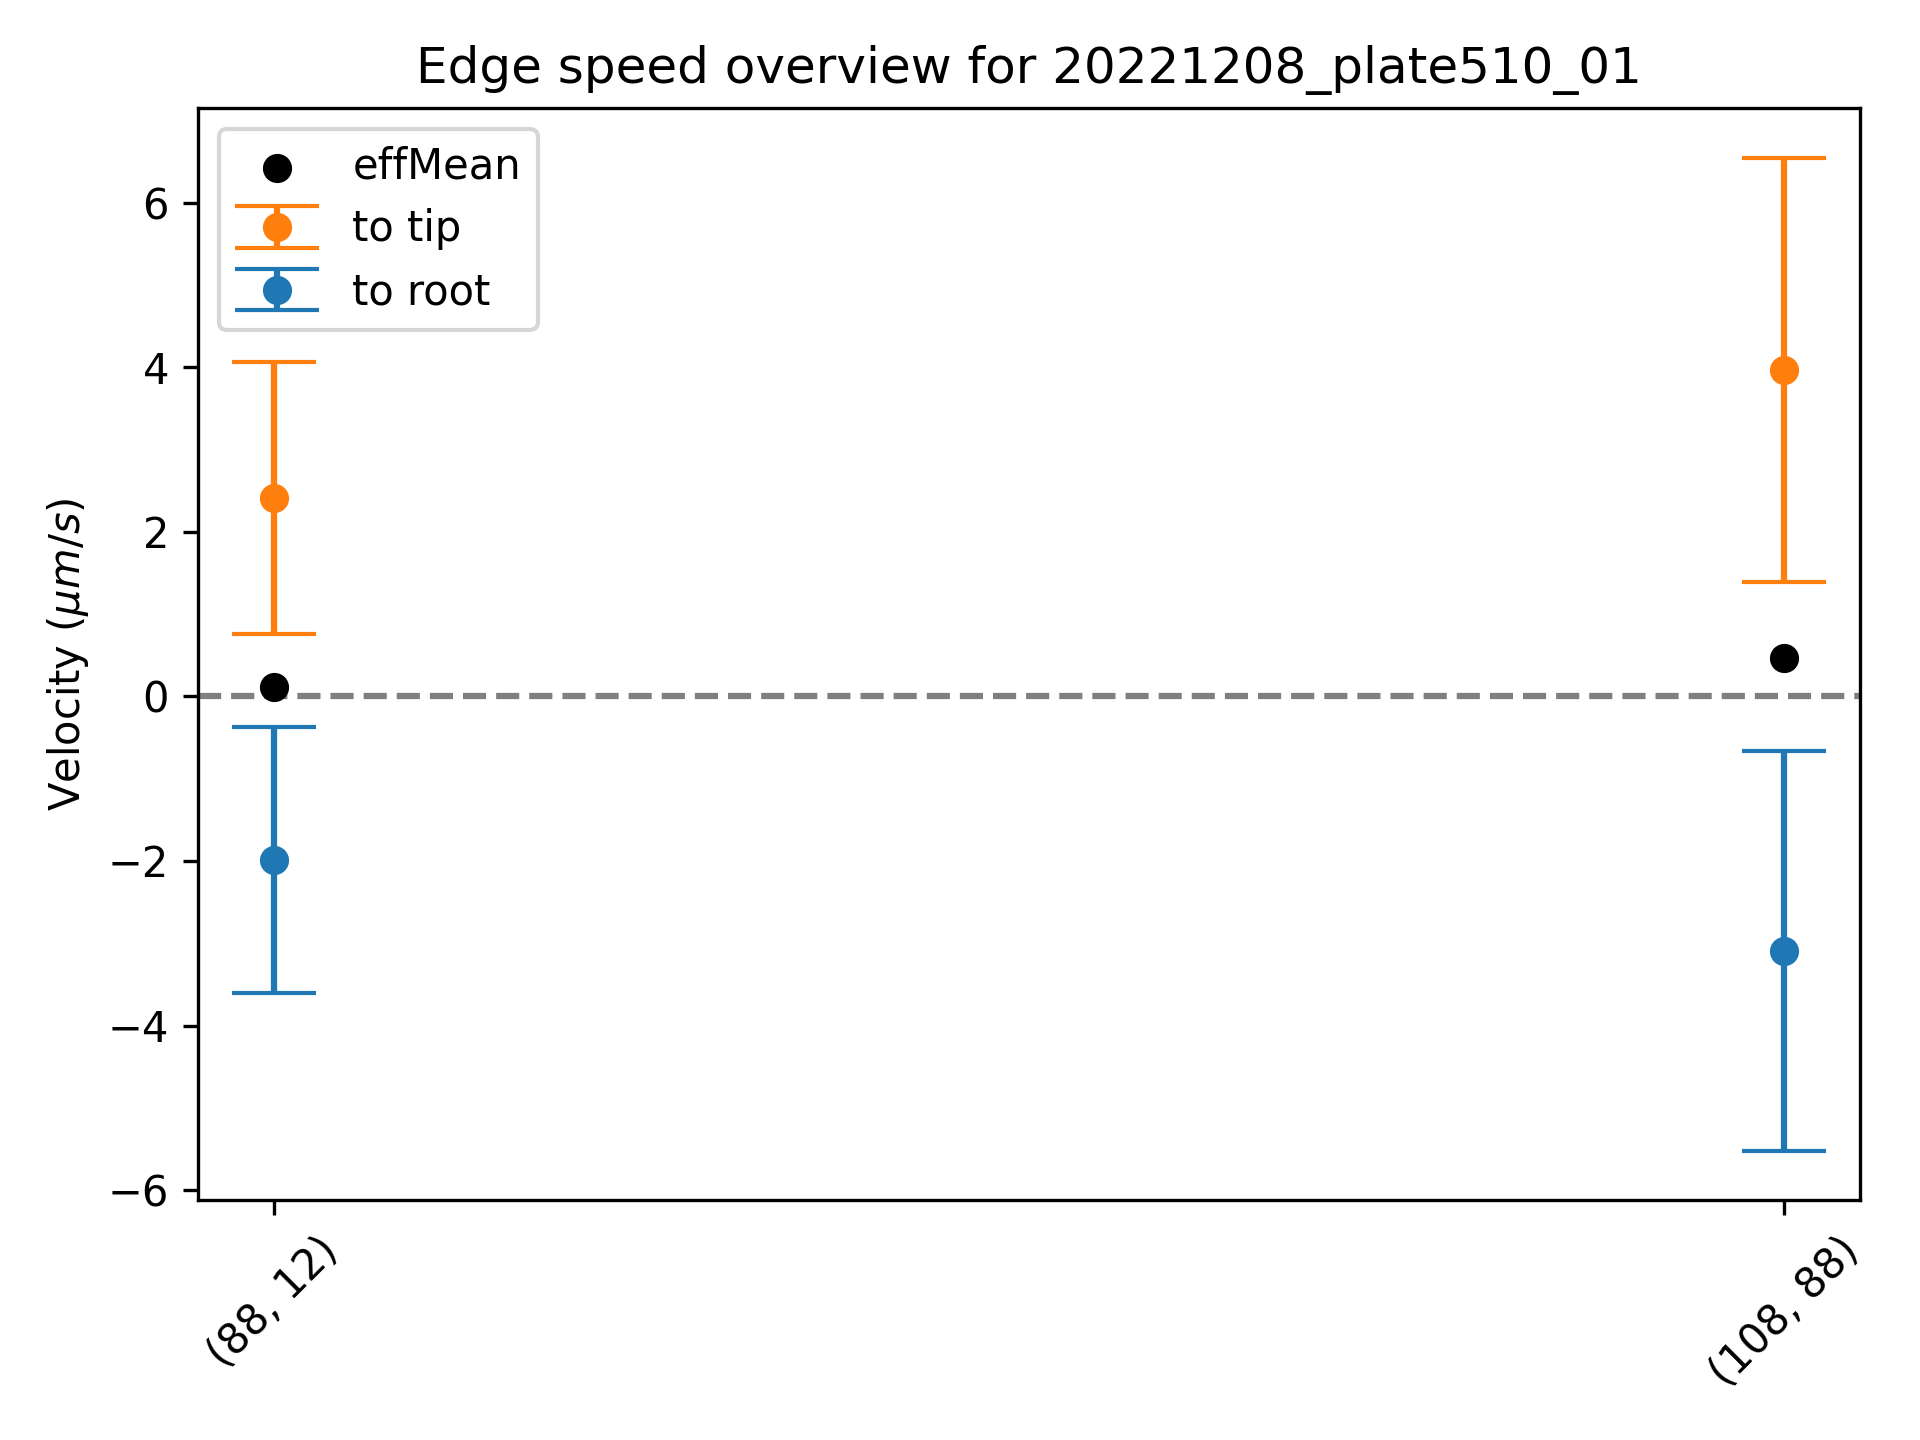

In [11]:
coco_vid_index_filter = coco_vid.edges_frame[coco_vid.edges_frame['coverage_tot'] > 0.2].index

coco_vid.edge_objs = [coco_vid.edge_objs[i] for i in  coco_vid_index_filter.values]
coco_vid.edges_frame = coco_vid.edges_frame.iloc[coco_vid_index_filter].reset_index(drop=True)

coco_vid.scatter_speeds_video()
coco_vid.edges_frame

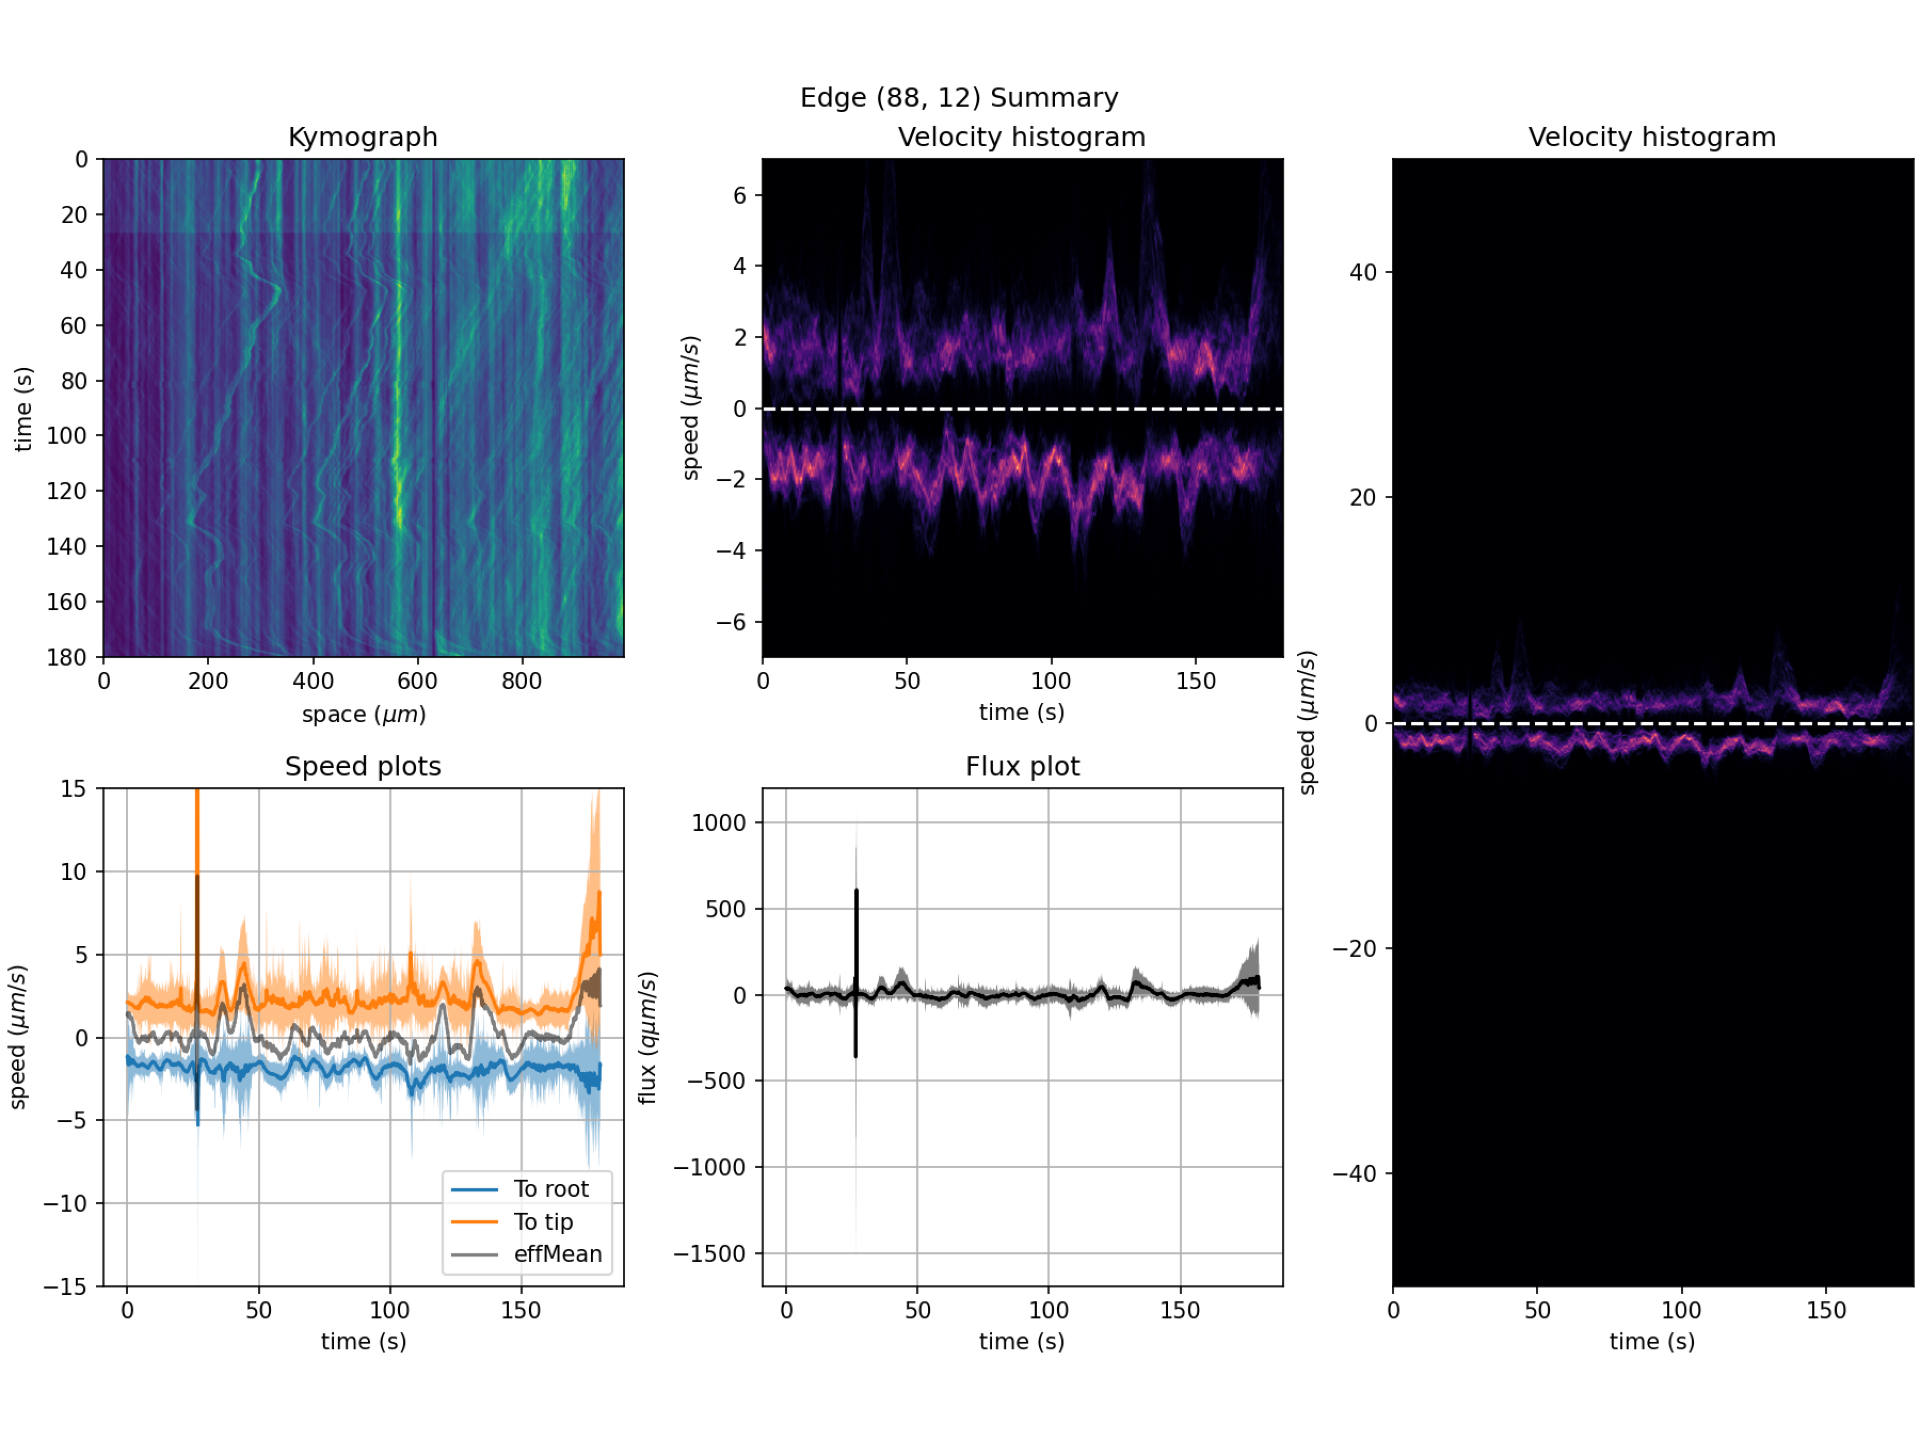

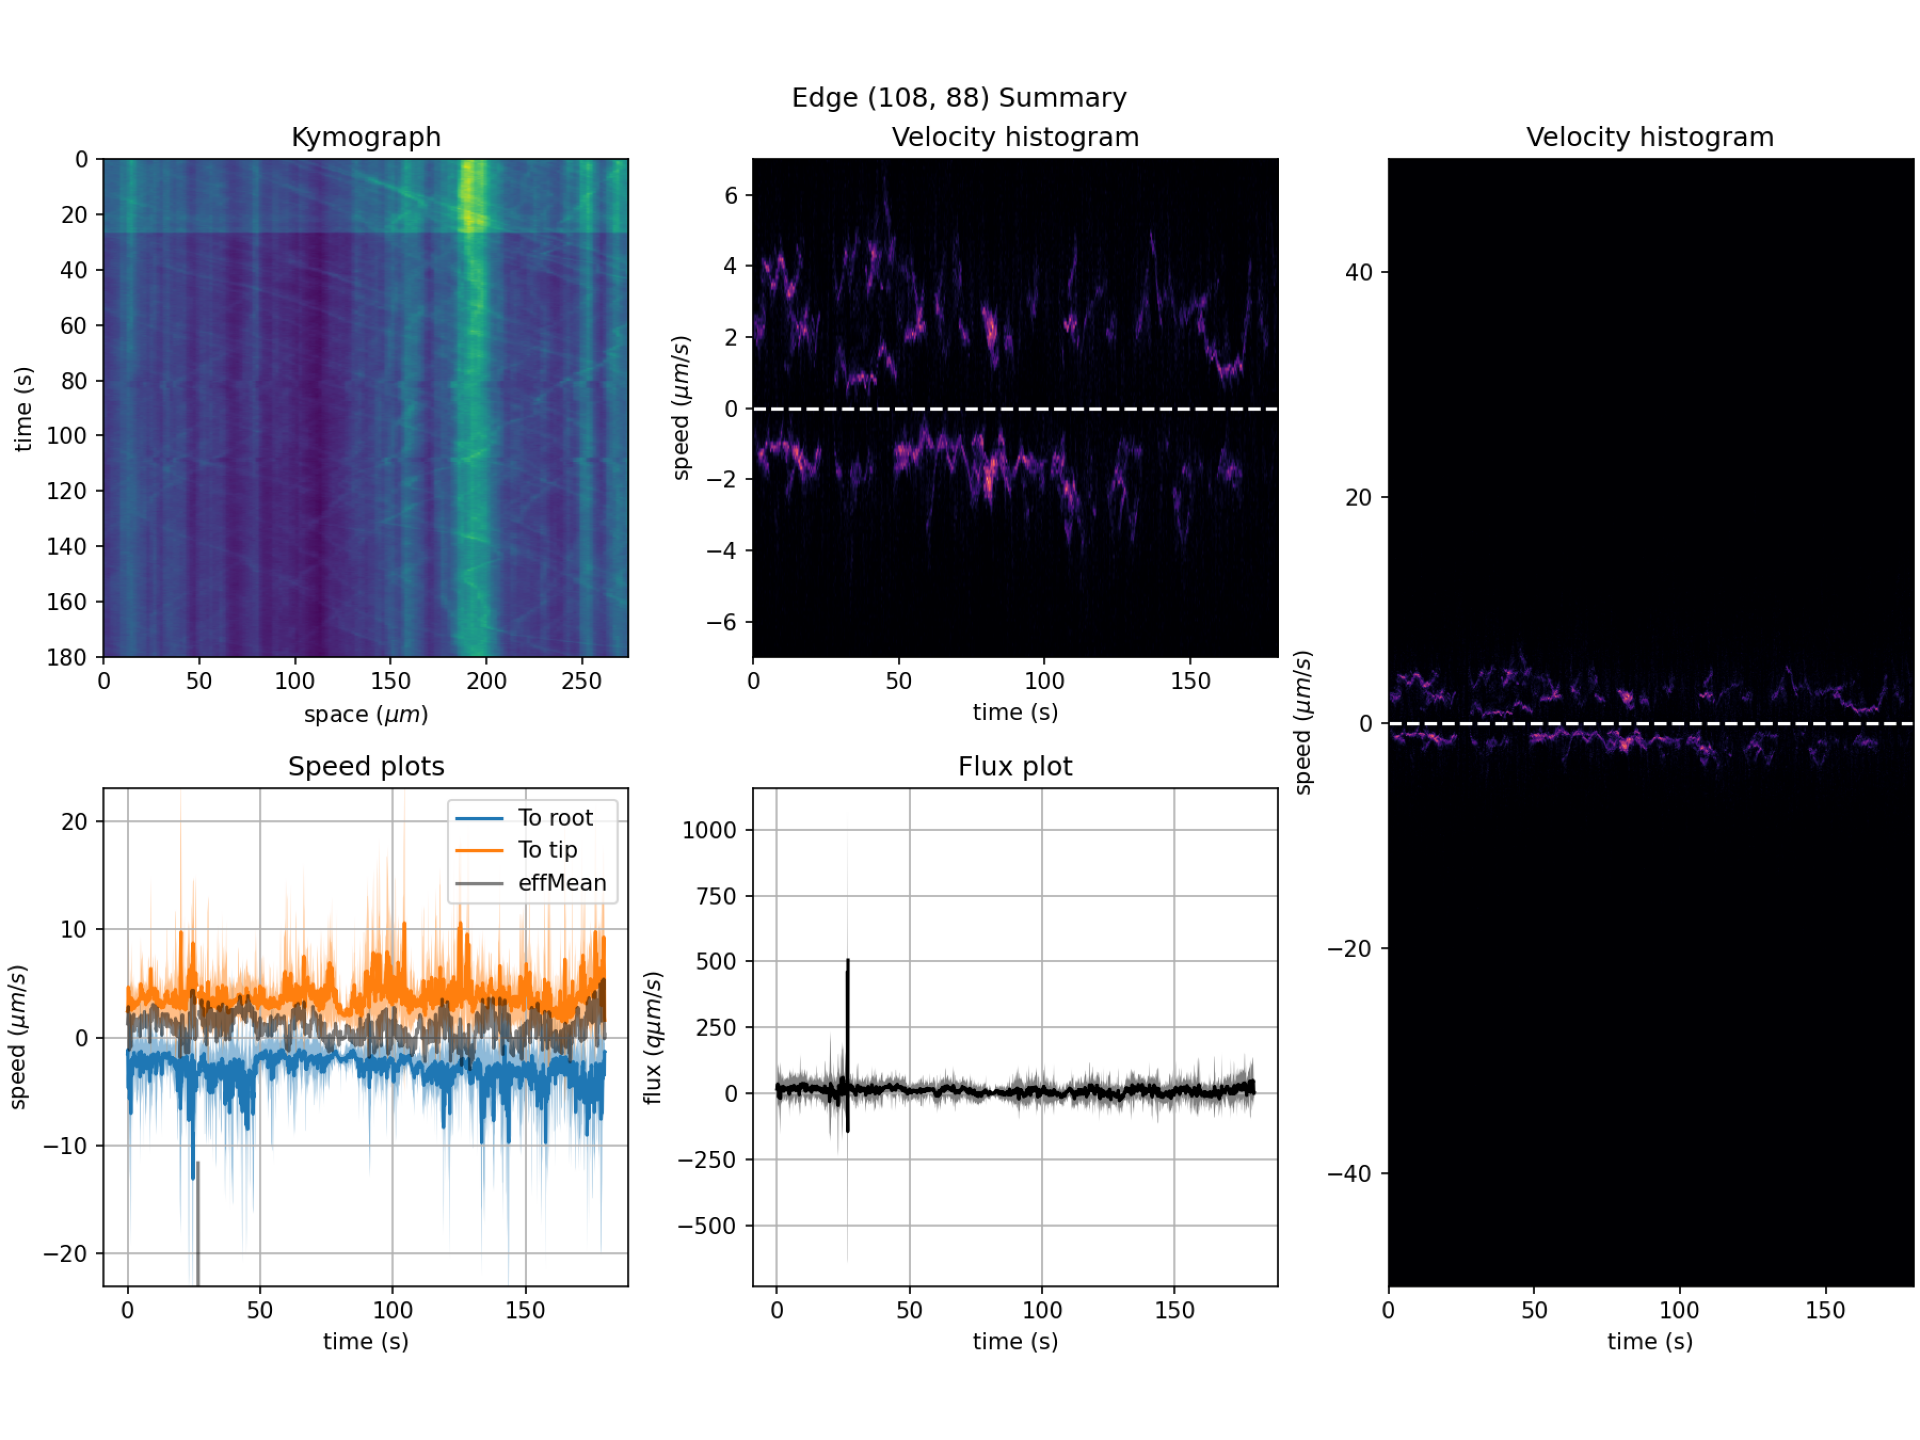

In [12]:
for edge in coco_vid.edge_objs:
    edge.show_summary()